In [1]:
!pip install --upgrade --force-reinstall numpy==1.26.4 scipy==1.13.1 pandapower==2.14.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 16.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 114.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 51.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 114.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78

In [2]:

import numpy as np
import pandas as pd
from scipy.stats import entropy
import pandapower as pp, pickle
net = pp.networks.case6ww()

In [3]:
with open("pandapower_net.pkl", "wb") as f:
    pickle.dump(net, f)
print("Saved pandapower_net.pkl")

Saved pandapower_net.pkl


In [4]:
import os, math, pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from sklearn.model_selection import train_test_split

DATA_CSV = "/kaggle/input/dataset/actual_data_6.csv"
YBUS_NPZ = "Ybus.npz"
PANDAPOWER_NET_PKL = "pandapower_net.pkl"
OUT_CSV = "ddim_stochastic_constrained_generated.csv"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_BUS = 6
NUM_FEATURES = 4 * NUM_BUS
BATCH_SIZE = 64
EPOCHS = 1000
LR = 1e-4
TIMESTEPS = 1000
DDIM_STEPS = 300
ETA = 0.2
SAMPLE_COUNT = 5000
GUIDANCE_LAMBDA = 1e-4

if not os.path.exists(DATA_CSV):
    raise FileNotFoundError("Need actual_data.csv generated from PF dataset code.")
df = pd.read_csv(DATA_CSV)
cols = df.columns.tolist()
if df.shape[1] != NUM_FEATURES:
    raise ValueError(f"Dataset must have {NUM_FEATURES} columns.")
data = df.values.astype(np.float32)

def load_ybus():
    if os.path.exists(YBUS_NPZ):
        arr = np.load(YBUS_NPZ)
        return arr["G"].astype(np.float64), arr["B"].astype(np.float64)
    if os.path.exists(PANDAPOWER_NET_PKL):
        import pandapower as pp
        with open(PANDAPOWER_NET_PKL, "rb") as f:
            net = pickle.load(f)
        nb = len(net.bus)
        Y = np.zeros((nb, nb), dtype=complex)
        for _, row in net.line.iterrows():
            i, j = int(row["from_bus"]), int(row["to_bus"])
            r, x = row["r_ohm_per_km"], row["x_ohm_per_km"]
            length = row.get("length_km", 1.0)
            y = 1 / complex(r * length, x * length)
            Y[i, i] += y; Y[j, j] += y; Y[i, j] -= y; Y[j, i] -= y
        return np.real(Y), np.imag(Y)
    raise FileNotFoundError("Need Ybus.npz or pandapower_net.pkl for guidance.")

G_np, B_np = load_ybus()
G = torch.tensor(G_np, dtype=torch.float32, device=DEVICE)
B = torch.tensor(B_np, dtype=torch.float32, device=DEVICE)

xmin, xmax = data.min(axis=0), data.max(axis=0)
range_eps = (xmax - xmin).copy()
range_eps[range_eps == 0] = 1e-6

def normalize(x):  
    return 2 * (x - xmin) / range_eps - 1

def denormalize(xn):  
    return ((xn + 1) / 2) * range_eps + xmin

data_tensor = torch.tensor(normalize(data), dtype=torch.float32, device=DEVICE)

p_min = torch.tensor(xmin[:NUM_BUS], device=DEVICE, dtype=torch.float32)
p_max = torch.tensor(xmax[:NUM_BUS], device=DEVICE, dtype=torch.float32)
q_min = torch.tensor(xmin[NUM_BUS:2*NUM_BUS], device=DEVICE, dtype=torch.float32)
q_max = torch.tensor(xmax[NUM_BUS:2*NUM_BUS], device=DEVICE, dtype=torch.float32)
v_min = torch.tensor(xmin[2*NUM_BUS:3*NUM_BUS], device=DEVICE, dtype=torch.float32)
v_max = torch.tensor(xmax[2*NUM_BUS:3*NUM_BUS], device=DEVICE, dtype=torch.float32)

def split_vec(x):
    p, q, v, th = x[:, :NUM_BUS], x[:, NUM_BUS:2*NUM_BUS], \
                  x[:, 2*NUM_BUS:3*NUM_BUS], x[:, 3*NUM_BUS:4*NUM_BUS]
    return torch.cat([p, th], 1), torch.cat([q, v], 1)

def concat_vec(x1, x2):
    p, th = x1[:, :NUM_BUS], x1[:, NUM_BUS:]
    q, v  = x2[:, :NUM_BUS], x2[:, NUM_BUS:]
    return torch.cat([p, q, v, th], 1)

def linear_beta_schedule(T, start=1e-4, end=0.02):
    return torch.linspace(start, end, T, device=DEVICE)

betas = linear_beta_schedule(TIMESTEPS)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, 0)

class MLPDenoiser(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 4096), nn.LayerNorm(4096), nn.SiLU(),
            nn.Linear(4096, 4096), nn.LayerNorm(4096), nn.SiLU(),
            nn.Linear(4096, 4096), nn.LayerNorm(4096), nn.SiLU(),
            nn.Linear(4096, dim)
        )

    def forward(self, x, t):
        t = t.float().unsqueeze(1) / TIMESTEPS 
        return self.net(torch.cat([x, t], 1))

model_dim = 4 * NUM_BUS
model = MLPDenoiser(model_dim).to(DEVICE)
opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3, betas=(0.9, 0.999))
mse = nn.MSELoss()

train_data, val_data = train_test_split(data_tensor, test_size=0.1, random_state=42)
Ntrain, Nval = train_data.shape[0], val_data.shape[0]

print("Training denoiser with validation monitoring...")
best_val = float("inf")

for ep in range(EPOCHS):
    model.train()
    perm = torch.randperm(Ntrain, device=DEVICE)
    tot_loss = 0.0

    for i in range(0, Ntrain, BATCH_SIZE):
        b = train_data[perm[i:i+BATCH_SIZE]]   # full vector (BATCH, 4B)
        x = b
        Bc = x.size(0)
        if Bc == 0:
            continue

        t = torch.randint(0, TIMESTEPS, (Bc,), device=DEVICE)

        eps = torch.randn_like(x)

        sA = torch.sqrt(alphas_cumprod[t]).unsqueeze(1)
        sO = torch.sqrt(1 - alphas_cumprod[t]).unsqueeze(1)

        x_t = sA * x + sO * eps

        pred = model(x_t, t)

        loss = mse(pred, eps)

        opt.zero_grad()
        loss.backward()
        opt.step()

        tot_loss += loss.item() * Bc

    train_loss = tot_loss / Ntrain

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, Nval, BATCH_SIZE):
            b = val_data[i:i+BATCH_SIZE]
            x = b
            Bc = x.size(0)
            if Bc == 0:
                continue
            t = torch.randint(0, TIMESTEPS, (Bc,), device=DEVICE)
            eps = torch.randn_like(x)
            sA = torch.sqrt(alphas_cumprod[t]).unsqueeze(1)
            sO = torch.sqrt(1 - alphas_cumprod[t]).unsqueeze(1)
            x_t = sA * x + sO * eps
            pred = model(x_t, t)
            val_loss += mse(pred, eps).item() * Bc
    val_loss /= Nval

    print(f"Epoch {ep+1:4d}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save({
            "model": model.state_dict(),
            "opt": opt.state_dict(),
            "epoch": ep,
            "val_loss": val_loss
        }, "best_ddim_denoiser.pth")
        print(f"  New best model saved (val_loss={val_loss:.6f})")

print("Training done.\n")

Training denoiser with validation monitoring...
Epoch    1/1000 | Train Loss: 0.161661 | Val Loss: 0.105729
  New best model saved (val_loss=0.105729)
Epoch    2/1000 | Train Loss: 0.090897 | Val Loss: 0.087230
  New best model saved (val_loss=0.087230)
Epoch    3/1000 | Train Loss: 0.081102 | Val Loss: 0.071925
  New best model saved (val_loss=0.071925)
Epoch    4/1000 | Train Loss: 0.071872 | Val Loss: 0.066868
  New best model saved (val_loss=0.066868)
Epoch    5/1000 | Train Loss: 0.072684 | Val Loss: 0.070423
Epoch    6/1000 | Train Loss: 0.071288 | Val Loss: 0.065195
  New best model saved (val_loss=0.065195)
Epoch    7/1000 | Train Loss: 0.063380 | Val Loss: 0.067860
Epoch    8/1000 | Train Loss: 0.065082 | Val Loss: 0.058587
  New best model saved (val_loss=0.058587)
Epoch    9/1000 | Train Loss: 0.062585 | Val Loss: 0.055506
  New best model saved (val_loss=0.055506)
Epoch   10/1000 | Train Loss: 0.058521 | Val Loss: 0.059726
Epoch   11/1000 | Train Loss: 0.059709 | Val Loss: 

In [5]:
p_min_np = xmin[:NUM_BUS]
p_max_np = xmax[:NUM_BUS]
q_min_np = xmin[NUM_BUS:2 * NUM_BUS]
q_max_np = xmax[NUM_BUS:2 * NUM_BUS]
v_min_np = xmin[2 * NUM_BUS:3 * NUM_BUS]
v_max_np = xmax[2 * NUM_BUS:3 * NUM_BUS]

p_min = torch.tensor(p_min_np, device=DEVICE, dtype=torch.float32)
p_max = torch.tensor(p_max_np, device=DEVICE, dtype=torch.float32)
q_min = torch.tensor(q_min_np, device=DEVICE, dtype=torch.float32)
q_max = torch.tensor(q_max_np, device=DEVICE, dtype=torch.float32)
v_min = torch.tensor(v_min_np, device=DEVICE, dtype=torch.float32)
v_max = torch.tensor(v_max_np, device=DEVICE, dtype=torch.float32)

def power_residuals(x_den):
    p = x_den[:, :NUM_BUS]
    q = x_den[:, NUM_BUS:2 * NUM_BUS]
    v = x_den[:, 2 * NUM_BUS:3 * NUM_BUS]
    th = x_den[:, 3 * NUM_BUS:4 * NUM_BUS]

    th_r = th * math.pi / 180

    vb = v.unsqueeze(-1)  
    vj = v.unsqueeze(-2)   
    dth = th_r.unsqueeze(-1) - th_r.unsqueeze(-2)  

    cosd = torch.cos(dth)
    sind = torch.sin(dth)

    G_b = G.unsqueeze(0)
    B_b = B.unsqueeze(0)

    P = (vb * vj * (G_b * cosd + B_b * sind)).sum(dim=-1) 
    Q = (vb * vj * (G_b * sind - B_b * cosd)).sum(dim=-1)  

    return torch.cat([p - P, q - Q], dim=1) 


def RH_sq(x_den):
    return (power_residuals(x_den) ** 2).sum(dim=1)


def RG_sq(x_den: torch.Tensor) -> torch.Tensor:
    p = x_den[:, :NUM_BUS]
    q = x_den[:, NUM_BUS:2 * NUM_BUS]
    v = x_den[:, 2 * NUM_BUS:3 * NUM_BUS]

    viol_p_upper = torch.relu(p - p_max) 
    viol_p_lower = torch.relu(p_min - p)
    viol_q_upper = torch.relu(q - q_max)
    viol_q_lower = torch.relu(q_min - q)
    viol_v_upper = torch.relu(v - v_max)
    viol_v_lower = torch.relu(v_min - v)

    viol = torch.cat(
        [
            viol_p_upper, viol_p_lower,
            viol_q_upper, viol_q_lower,
            viol_v_upper, viol_v_lower,
        ],
        dim=1,
    )

    return (viol ** 2).sum(dim=1) 


def make_ddim_timesteps(ddim_steps):
    step = TIMESTEPS // ddim_steps
    return torch.arange(TIMESTEPS - 1, -1, -step, device=DEVICE, dtype=torch.long)


print("Sampling using stochastic DDIM with physics guidance...")

n_samples = SAMPLE_COUNT
x_t = torch.randn(n_samples, NUM_FEATURES, device=DEVICE)
re = torch.tensor(range_eps, device=DEVICE, dtype=torch.float32)
xm = torch.tensor(xmin, device=DEVICE, dtype=torch.float32)
timesteps = make_ddim_timesteps(DDIM_STEPS)

for step_idx, t_idx in enumerate(tqdm(timesteps.tolist(), desc="Stochastic DDIM Sampling")):
    t = torch.full((n_samples,), t_idx, device=DEVICE, dtype=torch.long)

    with torch.no_grad():
        eps_pred = model(x_t, t) 
        sA = torch.sqrt(alphas_cumprod[t]).unsqueeze(1)
        sO = torch.sqrt(1 - alphas_cumprod[t]).unsqueeze(1)
        x0 = (x_t - sO * eps_pred) / sA 

    x_den = ((x0 + 1.0) / 2.0) * re + xm
    x_den = x_den.detach().clone().requires_grad_(True)

    R_total = RH_sq(x_den) + RG_sq(x_den)

    g_phys = grad(R_total.sum(), x_den, retain_graph=False, create_graph=False)[0]

    grad_norm = g_phys * (re / 2.0)
    lam_t = GUIDANCE_LAMBDA * ((t.float() + 1.0) / TIMESTEPS).unsqueeze(1)

    x0_guided = x0 - lam_t * grad_norm
    x0_guided = torch.clamp(x0_guided, -1.0, 1.0)

    a_bar_t = alphas_cumprod[t].unsqueeze(1)

    if step_idx < len(timesteps) - 1:
        t_prev_idx = timesteps[step_idx + 1].item()
        t_prev = torch.full((n_samples,), t_prev_idx, device=DEVICE, dtype=torch.long)
        a_bar_prev = alphas_cumprod[t_prev].unsqueeze(1)
    else:
        a_bar_prev = torch.ones_like(a_bar_t)
        t_prev_idx = -1

    if t_prev_idx == -1:
        x_t = x0_guided.detach()
        continue

    denom = (1.0 - a_bar_t).clamp(min=1e-8)
    eps_pred = (x_t - torch.sqrt(a_bar_t) * x0_guided) / torch.sqrt(denom)

    frac = ((1.0 - a_bar_prev) / denom).clamp(min=0.0)
    inner = (1.0 - (a_bar_t / a_bar_prev)).clamp(min=0.0)
    sigma = ETA * torch.sqrt(frac * inner)

    sigma2 = sigma * sigma
    sqrt_term = (1.0 - a_bar_prev - sigma2).clamp(min=0.0)
    sqrt_term = torch.sqrt(sqrt_term)

    x_prev_mean = torch.sqrt(a_bar_prev) * x0_guided + sqrt_term * eps_pred
    z = torch.randn_like(x_t)
    x_t = x_prev_mean + sigma * z
    x_t = x_t.detach()
    
gen_norm = x_t.cpu().numpy()
gen_denorm = denormalize(gen_norm)

bad = ~np.isfinite(gen_denorm)
if bad.any():
    print(f"[warn] {bad.sum()} invalid values detected; replacing with finite values.")
    gen_denorm = np.nan_to_num(
        gen_denorm,
        nan=0.0,
        posinf=0.0,
        neginf=0.0
    )

OUT_CSV = f"ddim_stochastic_constrained_generated_{ETA}.csv"

pd.DataFrame(gen_denorm, columns=cols).to_csv(
    OUT_CSV,
    index=False
)

print(f"\nGenerated {len(gen_denorm)} stochastic-DDIM guided samples → {OUT_CSV}")


Sampling using stochastic DDIM with physics guidance...


Stochastic DDIM Sampling: 100%|██████████| 334/334 [00:18<00:00, 18.12it/s]



Generated 5000 stochastic-DDIM guided samples → ddim_stochastic_constrained_generated_0.2.csv


In [6]:
import pandas as pd
actual = pd.read_csv("/kaggle/input/test-data6/test_data_6.csv")
generated = pd.read_csv("ddim_stochastic_constrained_generated_0.2.csv")

In [12]:
BASE_MVA = 100
p_cols = [c for c in actual.columns if c.startswith("P")]
q_cols = [c for c in actual.columns if c.startswith("Q")]
v_cols = [c for c in actual.columns if c.startswith("V")]
theta_cols = [c for c in actual.columns if c.startswith("Th")]

num_buses = len(p_cols)

actual_nonpu = actual.copy()
generated_nonpu = generated.copy()

for col in p_cols:
    actual_nonpu[col] = actual[col] * BASE_MVA
    generated_nonpu[col] = generated[col] * BASE_MVA

for col in q_cols:
    actual_nonpu[col] = actual[col] * BASE_MVA
    generated_nonpu[col] = generated[col] * BASE_MVA

vn_kv = net.bus.vn_kv.values
for i, col in enumerate(v_cols):
    actual_nonpu[col] = actual[col] * vn_kv[i]
    generated_nonpu[col] = generated[col] * vn_kv[i]

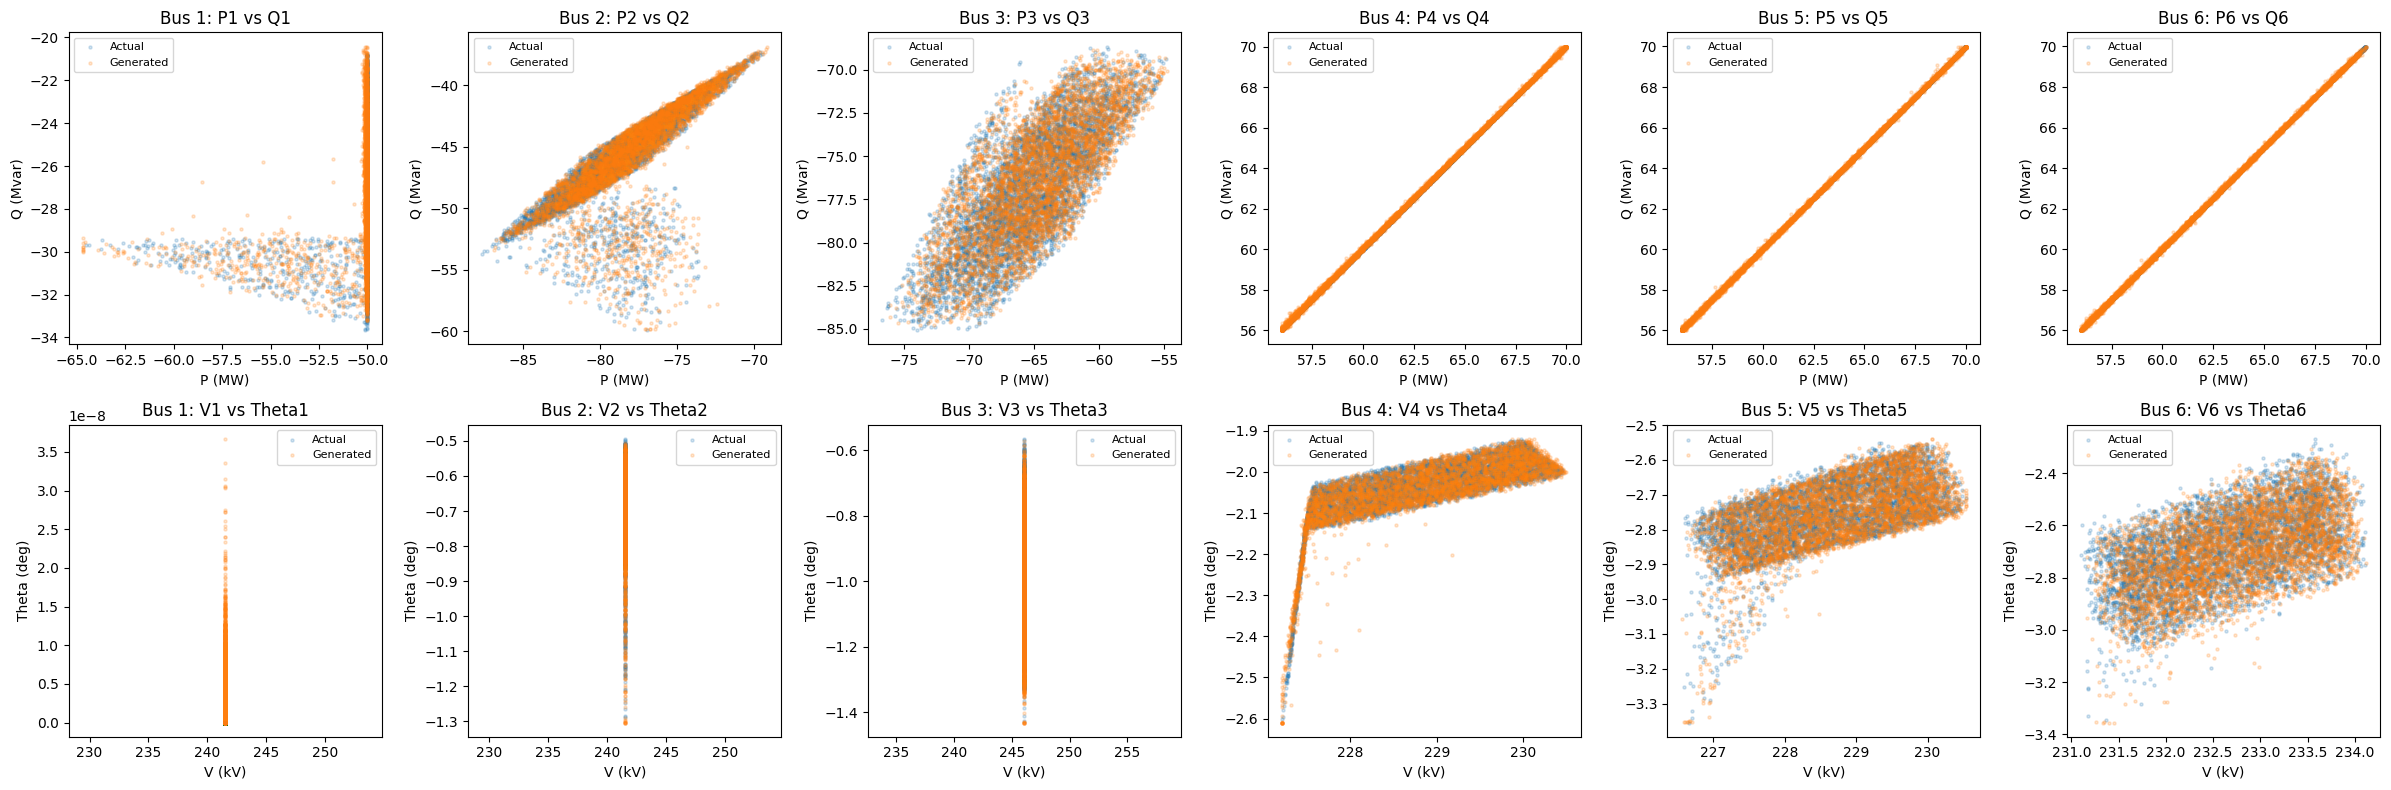

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 6, figsize=(24, 8))

for i in range(NUM_BUS):          
    bus_id = i + 1                  

    p_col = f"P{i}"
    q_col = f"Q{i}"
    v_col = f"V{i}"
    th_col = f"Theta{i}"

    ax1 = axes[0, i]
    ax1.scatter(actual_nonpu[p_col], actual_nonpu[q_col], alpha=0.2, s=5, label="Actual")
    ax1.scatter(generated_nonpu[p_col], generated_nonpu[q_col], alpha=0.2, s=5, label="Generated")
    ax1.set_title(f"Bus {bus_id}: P{bus_id} vs Q{bus_id}")
    ax1.set_xlabel("P (MW)")
    ax1.set_ylabel("Q (Mvar)")
    ax1.legend(fontsize=8)

    ax2 = axes[1, i]
    ax2.scatter(actual_nonpu[v_col], actual_nonpu[th_col], alpha=0.2, s=5, label="Actual")
    ax2.scatter(generated_nonpu[v_col], generated_nonpu[th_col], alpha=0.2, s=5, label="Generated")
    ax2.set_title(f"Bus {bus_id}: V{bus_id} vs Theta{bus_id}")
    ax2.set_xlabel("V (kV)")
    ax2.set_ylabel("Theta (deg)")
    ax2.legend(fontsize=8)

plt.tight_layout()
plt.show()


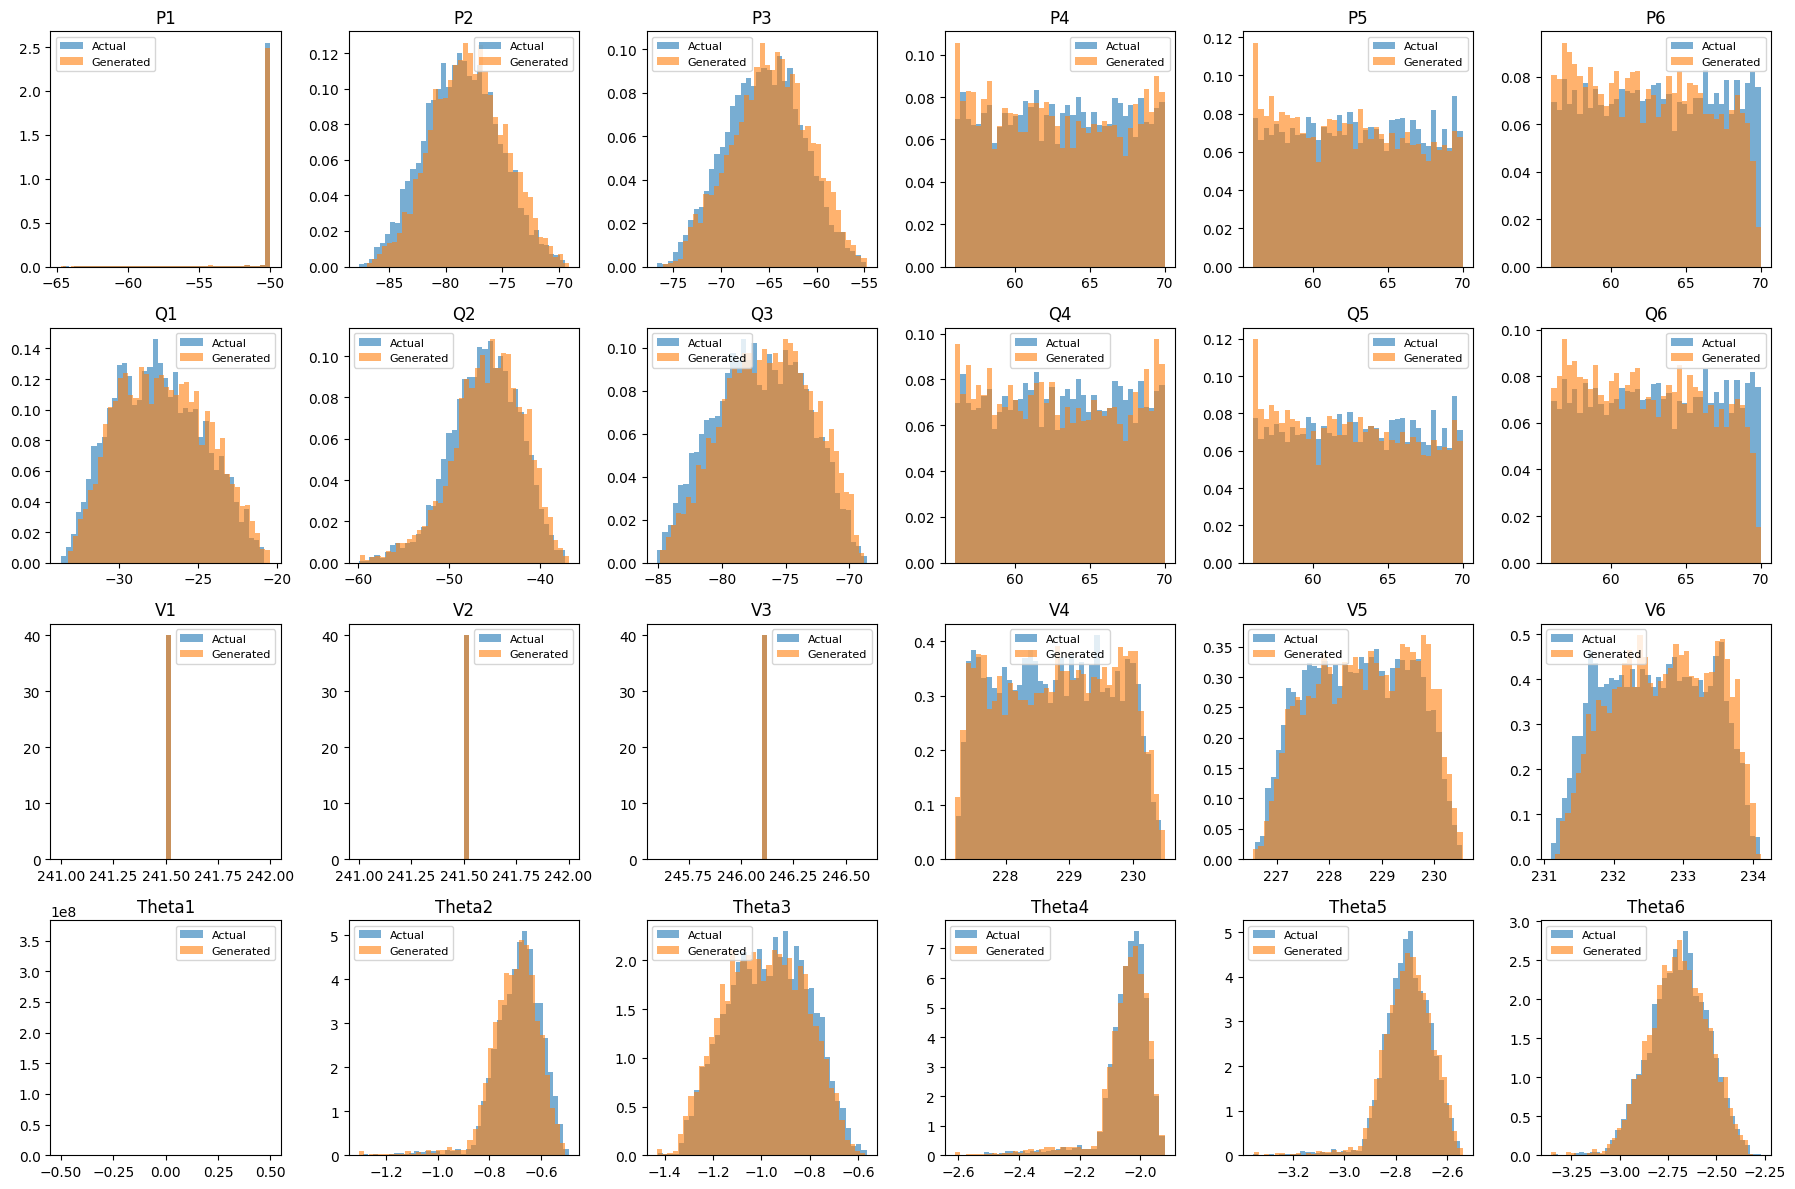

In [14]:
fig, axes = plt.subplots(4, 6, figsize=(18, 12))
axes = axes.flatten()

bus_offset = 1 

for idx, col in enumerate(actual_nonpu.columns):
    ax = axes[idx]

    if col.startswith("Theta") and col[5:].isdigit():
        display_bus = int(col[5:]) + bus_offset
        label = f"Theta{display_bus}"
    elif col.startswith("Th") and col[2:].isdigit():
        display_bus = int(col[2:]) + bus_offset
        label = f"Theta{display_bus}"
    elif col[1:].isdigit():  
        display_bus = int(col[1:]) + bus_offset
        label = f"{col[0]}{display_bus}"
    else:
        label = col

    ax.hist(actual_nonpu[col], bins=40, alpha=0.6, density=True, label='Actual')
    ax.hist(generated_nonpu[col], bins=40, alpha=0.6, density=True, label='Generated')
    ax.set_title(f"{label}")
    ax.legend(fontsize=8)

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [15]:
pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
import ot
from scipy.spatial.distance import cdist
import numpy as np

def calculate_w1_distance_for_eta(actual_df, gen_df, eta):
    distances = []
    num_bus = 6

    cols = (
        [f"P{i}" for i in range(num_bus)] +
        [f"Q{i}" for i in range(num_bus)] +
        [f"V{i}" for i in range(num_bus)] +
        [f"Theta{i}" for i in range(num_bus)]
    )

    theta_cols = [f"Theta{i}" for i in range(num_bus)]
    actual_df[theta_cols] = np.deg2rad(actual_df[theta_cols])
    gen_df[theta_cols] = np.deg2rad(gen_df[theta_cols])

    data_gt = actual_df[cols].values
    data_syn = gen_df[cols].values

    n = len(data_gt)
    m = len(data_syn)

    a = np.ones(n) / n
    b = np.ones(m) / m

    M = cdist(data_gt, data_syn, metric='euclidean')

    wasserstein_dist = ot.emd2(a, b, M)
    distances.append(wasserstein_dist)

    print(eta, "P Q V Theta W1 distance:", wasserstein_dist)
    return wasserstein_dist

calculate_w1_distance_for_eta(actual, generated, 0.2)


2025-11-26 07:10:20.551680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764141020.720668      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764141020.770866      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

0.2 P Q V Theta W1 distance: 0.020789354970734197


/usr/local/lib/python3.11/dist-packages/ot/lp/_network_simplex.py:574: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


0.020789354970734197

In [17]:
from scipy.stats import entropy
import numpy as np
import pandas as pd

def kl_divergence_featurewise(actual_df, gen_df, bins=80, eps=1e-12):
    actual = actual_df.copy()
    gen = gen_df.copy()

    theta_cols = [c for c in actual.columns if "Theta" in c]

    if len(theta_cols) > 0:
        actual[theta_cols] = np.deg2rad(actual[theta_cols])
        gen[theta_cols] = np.deg2rad(gen[theta_cols])

    cols = actual.columns.tolist()
    data_gt = actual.values
    data_syn = gen.values

    kl_results = {}

    for i, col in enumerate(cols):
        real_vals = data_gt[:, i]
        test_vals = data_syn[:, i]

        hist_range = (
            min(real_vals.min(), test_vals.min()),
            max(real_vals.max(), test_vals.max())
        )

        real_hist, _ = np.histogram(real_vals, bins=bins, range=hist_range, density=True)
        test_hist, _ = np.histogram(test_vals, bins=bins, range=hist_range, density=True)

        real_hist += eps
        test_hist += eps

        real_hist /= real_hist.sum()
        test_hist /= test_hist.sum()

        kl = entropy(real_hist, test_hist)
        kl_results[col] = kl

    return pd.DataFrame(kl_results, index=["KL"]).T
    
kl = kl_divergence_featurewise(actual, generated)
print(kl)
print(kl["KL"].mean())

              KL
P0      0.040557
P1      0.071212
P2      0.113635
P3      0.021363
P4      0.021940
P5      0.041998
Q0      0.058136
Q1      0.031534
Q2      0.070467
Q3      0.018988
Q4      0.022754
Q5      0.042713
V0      0.000000
V1      0.000000
V2      0.000000
V3      0.023332
V4      0.023242
V5      0.062823
Theta0  1.270113
Theta1  0.079623
Theta2  0.044543
Theta3  0.036360
Theta4  0.022931
Theta5  0.067826
0.0910871278104699
